# 入力文字列の処理

--- text2corpus
--- create_co_matrix
--- co2ppmi
--- svd


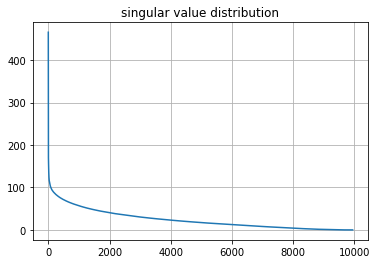

9944 [465.422 276.214 203.937 195.175 176.498 169.919 167.381 162.851 155.451
 154.682 146.881 142.782 140.159 138.608 137.293 136.018 132.448 131.461
 130.268 129.559 127.771 125.082 123.951 122.373 122.312 120.468 118.888
 118.387 117.427 116.503 116.303 115.908 115.768 115.564 114.521 114.32
 114.232 113.756 113.397 112.974 111.874 111.321 110.837 110.638 110.215
 109.874 109.41  108.742 108.2   108.11  107.989 107.983 107.617 107.065
 106.98  106.394 106.293 105.863 105.77  105.505 105.396 104.733 104.638
 104.298 104.211 103.927 103.416 103.119 102.988 102.826 102.625 102.419
 102.061 101.826 101.72  101.506 101.337 101.193 100.775 100.66  100.597
 100.244 100.099  99.91   99.652  99.42   99.315  98.899  98.825  98.78
  98.766  98.643  98.372  98.343  98.181  97.965  97.773  97.766  97.512
  97.392]


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

class WordDictionary:
    """
    受け取ったテキストを単語に分解して単語ID（整数）の配列に変換する辞書
    """
    
    def __init__(self):
        self.word2index = {}
        self.index2word = []
        self.word_count = []
        self.latest_id = 0
    
    def text2corpus(self, text):
        result = []
        for word in text.lower().replace('.', ' .').replace(',', ' ,').replace('!', ' !').replace('?', ' ?').split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.latest_id
                self.index2word.append(word)
                self.word_count.append(0)
                self.latest_id += 1
            i = self.word2index[word]
            result.append(i)
            self.word_count[i] += 1
        return np.array(result)

def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    コーパスの共起行列を作成する
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    for i in range(corpus_size):
        for j in range(1, window_size+1):
            if i+j < corpus_size:
                co_matrix[corpus[i]][corpus[i+j]] += 1
            if 0 <= i-j:
                co_matrix[corpus[i]][corpus[i-j]] += 1
    return co_matrix

def co2ppmi(co_matrix, eps=1.0e-8):
    """
    PMI (Pointwize Mutual Information, 相互情報量)
    PPMI (Positive PMI)
    """
    cnt_each_word = co_matrix.sum(axis=0)
    cnt_total = cnt_each_word.sum()
    ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    for i in range(ppmi_matrix.shape[0]):
        for j in range(ppmi_matrix.shape[1]):
            pmi = np.log2((cnt_total * co_matrix[i, j]) / (cnt_each_word[i] * cnt_each_word[j]) + eps)
            ppmi_matrix[i][j] = max(0, pmi)
    return ppmi_matrix

def similar_with(word, U, wd, num_result=10, dim=10):
    """
    与えられた単語に近い単語を返す
    """
    u = np.copy(U[:, :dim])
    print('--- {} [次元圧縮: {} => {}]---'.format(word, U.shape[1], dim))
    if word not in wd.word2index:
        print('<No Result>')
    u = (u.T / np.sqrt((u * u).sum(axis=1))).T
    i = wd.word2index[word]
    result_ids = np.argsort(u.dot(u[i]))[::-1][1:num_result+1]
    for j in result_ids:
        print('{} : {}'.format(wd.index2word[j], u[i].dot(u[j])))

wd = WordDictionary()

#text = 'This is a pen. I like this pen. This pen is mine.'
text = 'You say goodbye and I say hello.'
#with open('../data/nlp/sample.txt', 'r') as f:
#    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/alice_in_wonderland.txt') as f:
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/christmas_carol.txt') as f:
    # Christmas Carol
    # https://www.gutenberg.org/files/46/46-0.txt
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/penn_treebank_partial.txt') as f:
    # Penn Treebank dataset (not official)
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')

print('--- text2corpus')
corpus = wd.text2corpus(text)
print('--- create_co_matrix')
co = create_co_matrix(corpus, len(wd.index2word))
print('--- co2ppmi')
ppmi = co2ppmi(co)
print('--- svd')
U, S, V = np.linalg.svd(ppmi)

np.set_printoptions(precision=3)
#print(wd.word2index)
#print(wd.word_count)
#print(co)
#print(ppmi)
#print(U, S, V)

# 特異値の大きさの分布
s = np.array([[i, S[i]] for i in range(len(S))])
plt.title('singular value distribution')
plt.plot(s[:,0], s[:,1])
plt.grid()
plt.show()
print(len(S), S[:100])

# 単語を座標空間にプロット
ids = np.array(wd.word_count) >= 100
plt.scatter(U[ids, 0], U[ids, 1], s=10)
for i in range(ppmi.shape[0]):
    if ids[i]:
        plt.annotate(wd.index2word[i], (U[i, 0], U[i, 1]))
plt.show()

In [8]:
for w in ['the', 'a', 'have', 'of', 'alice', 'tom', 'this', 'walk', 'sunny']:
    for d in [1000, 100, 10]:
        print()
        similar_with(w, U, wd, num_result=10, dim=d)


--- the [次元圧縮: 9944 => 1000]---
the : 1.0
.v : 0.09924142062664032
deficiency : 0.0972507894039154
cough : 0.09681417793035507
guerrillas : 0.08359284698963165
freeway : 0.07716701924800873
troop : 0.06586956232786179
scattered : 0.06520272046327591
border : 0.063118577003479
joins : 0.06068948283791542

--- the [次元圧縮: 9944 => 100]---
the : 0.9999999403953552
of : 0.5497462153434753
<unk> : 0.4098791778087616
a : 0.4098617732524872
cypress : 0.3713435232639313
law : 0.3122788071632385
second : 0.3038176894187927
this : 0.2966763377189636
current : 0.2911580204963684
legislation : 0.28222379088401794

--- the [次元圧縮: 9944 => 10]---
the : 1.0
a : 0.9404829144477844
its : 0.9134922027587891
an : 0.8875625729560852
his : 0.8719176650047302
or : 0.8526865839958191
one : 0.8423053026199341
another : 0.8361328840255737
this : 0.8257612586021423
of : 0.8128302693367004

--- the [次元圧縮: 9944 => 5]---
the : 1.0
n : 0.9647706151008606
last : 0.9612309336662292
which : 0.9445730447769165
earlier : 

### 1. 前提：特異値分解定理

$$m \times n$$ 行列

$$
A = \begin{pmatrix}
    a_{11} & \cdots & a_{1n}\\
    \vdots &  & \vdots \\
    a_{m1} & \cdots & a_{mn}\\
\end{pmatrix}
$$

に対して、$$m, n$$ 次の直行行列

$$
\begin{eqnarray}
    U = \begin{pmatrix}
        u_{11} & \cdots & u_{1m}\\
        \vdots &  & \vdots \\
        u_{m1} & \cdots & u_{mm}\\
    \end{pmatrix}
    = \left( \boldsymbol{u}_1, \cdots, \boldsymbol{u}_m \right)
    \\
    V = \begin{pmatrix}
        v_{11} & \cdots & v_{1n}\\
        \vdots & & \vdots \\
        v_{n1} & \cdots & v_{nn}\\
    \end{pmatrix}
    = \left( \boldsymbol{v}_1, \cdots, \boldsymbol{v}_m \right)
\end{eqnarray}
$$

と $$m \times n$$ 行列

$$
S = \begin{cases}
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_q \\
        0 & \cdots & 0 \\
        \vdots & & \vdots \\
        0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \gt n
    \\
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_q
    \end{pmatrix}
    & {\rm if} \quad m = n
    \\
    \begin{pmatrix}
        s_1 &  & 0 & 0 & \cdots & 0 \\
        & \ddots & & \vdots & & \vdots \\
        0 &  & s_q & 0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \lt n
\end{cases}
$$

$$
s_1 \ge s_2 \ge \cdots \ge s_q
$$

$$
q = \min (m, n)
$$

が存在し、

$$
A = USV^T
$$

### 2. 特異値分解の実行

次元削減対象の $$n$$ 次元の行ベクトル $$m$$ 個を縦に並べた行列を前節の $$A$$ に当てはめる。

（以下、ToDo）

### 3. 次元の削減

$$t$$ 次元まで削減したい場合、
- $$U'$$: $$U$$ の $$t$$ 列目までの要素を抜き出した $$m \times t$$ 行列
- $$S'$$: $$S$$ の $$t$$ 行目、$$t$$ 列目までの要素を抜き出した $$t \times t$$ 行列
- $$V'$$: $$V$$ の $$t$$ 列目までの要素を抜き出した $$n \times t$$ 行列

を用いて計算した

$$
A' \equiv U' S' V'^T
$$

を $$A$$ の近似として用いれば良い。

### SVD の実装

$$
A = USV^T
$$

に右から $$A^T$$ をかけて、

$$
\begin{eqnarray}
    AA^T &=& USV^T (USV^T)^T \\
         &=& USV^T VS^T U^T \\
         &=& USS^T U^T
\end{eqnarray}
$$

ここで、$$V$$ が直交行列であること（$$V^T = V^{-1}$$）を用いた。

右から $$U$$ をかけると、$$U$$ も直交行列であるから、

$$
\begin{eqnarray}
    AA^T U &=& U SS^T
    \\
    (AA^T)\left( \boldsymbol{u}_1, \cdots, \boldsymbol{u}_m \right)
    &=&
    \left( \boldsymbol{u}_1, \cdots, \boldsymbol{u}_m \right)
    \begin{pmatrix}
        s^2_1 &        &       & O \\
              & \ddots &       &   \\
              &        & s^2_q &   \\
            O &        &       & O \\
    \end{pmatrix}
\end{eqnarray}
$$

よって、

$$
(AA^T) \boldsymbol{u}_i = s^2_i \boldsymbol{u}_i
$$

これは、行列 $$AA^T$$ の固有方程式になっている。  
すなわち、$$AA^T$$ の固有値問題を解けば $$U, S$$ が求まる。

$$V$$ についても、$$A = USV^T$$ に左から $$A^T$$ をかけて同様に計算していくと

$$(A^T A) V = V S^T S$$

が得られ、行列 $$A^T A$$ の固有方程式

$$
(A^T A) \boldsymbol{v}_i = s^2_i \boldsymbol{v}_i
$$

を解くことで $$V$$ も求まる。